# 注意力汇聚：Nadaraya-Watson核回归(没什么用)

In [259]:
import torch
from torch import nn
import self_d2l

随机数据集

In [262]:
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5)
def f(x):
    return 2 * torch.sin(x) + x ** 0.8
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
x_test = torch.arange(0, 5, 0.1)
y_truth = f(x_test)
n_test = len(x_test)
n_test

50

绘制函数

In [265]:
def plot_kernel_reg(y_hat):
    self_d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    self_d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

平均汇聚（池化）

汇聚跟池化一个意思

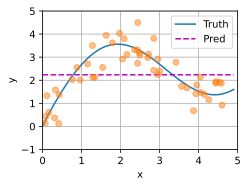

In [6]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
# torch.repeat_interleave 是PyTorch库中的一个函数，用于按照指定的重复模式对张量进行扩展
# torch.repeat_interleave(input, repeats, dim=None) input: 输入张量,repeats: 表示每个元素重复次数的一维张量
# torch.repeat_interleave([1,2,3], [1,2,3]) 结果是[1, 2, 2, 3, 3, 3]
plot_kernel_reg(y_hat)

非参数注意力汇聚

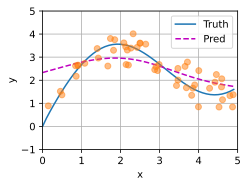

In [270]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train)) # x_test中每个元素重复n_train次然后reshape成(n_test,n_train)
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

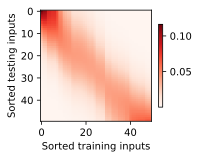

In [272]:
self_d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), # 相当于将(M, N)大小的数组变为(1, 1, M, N)
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [18]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape # batch matrix multiple

torch.Size([2, 1, 6])

In [31]:
weights = torch.ones((2, 10)) * 0.1
values = torch.arange(20.0).reshape((2, 10))
print(weights.unsqueeze(1).shape, values.unsqueeze(-1).shape)
print(torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1)))

torch.Size([2, 1, 10]) torch.Size([2, 10, 1])
tensor([[[ 4.5000]],

        [[14.5000]]])


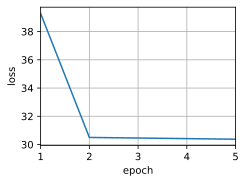

In [34]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

"""训练"""
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = self_d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))


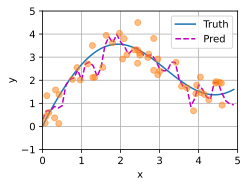

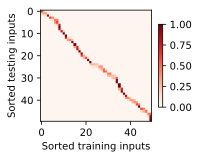

In [39]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)
self_self_d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

# 注意力评分

In [274]:
import math
import torch
from torch import nn


## 掩码softmax
在decoder时，要一个字一个字地生成，所以后面地输入不能纳入注意力之中

In [84]:
def masked_softmax(X, valid_lens):
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1) # 变成一维
    X = self_d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
    return nn.functional.softmax(X.reshape(shape), dim=-1)

In [86]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4417, 0.5583, 0.0000, 0.0000],
         [0.5183, 0.4817, 0.0000, 0.0000]],

        [[0.3563, 0.2728, 0.3709, 0.0000],
         [0.3485, 0.3135, 0.3380, 0.0000]]])

In [13]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2755, 0.2790, 0.4456, 0.0000]],

        [[0.3503, 0.6497, 0.0000, 0.0000],
         [0.3497, 0.2670, 0.2087, 0.1746]]])

## 加性注意力
查询q和键k是不同长度时矢量时，可以用加性注意力评分。

$a(q,k) = \vec{w}_v^Ttanh(\vec{W}_q\vec{q} + \vec{W}_k\vec{k})\in R$


In [14]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)


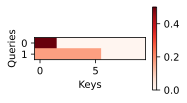

In [15]:
"""演示AdditiveAttention"""
import self_self_d2l
queries, keys = torch.normal(0, 1, (2, 1 ,20)), torch.ones(2, 10, 2)
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
print(attention(queries, keys, values, valid_lens))
self_self_d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

## 缩放点积注意力
$$a(q,k) = \vec{q}^T\vec{k}/\sqrt{d}$$
小批量计算公式为：$softmax(\frac{QK^T}{\sqrt{d}})V \in R^{n\times v}$

In [16]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])


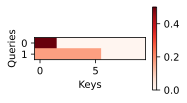

In [17]:
"""演示"""
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
print(attention(queries, keys, values, valid_lens))
self_self_d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# 使用注意力机制的seq2seq

## Bahdanau注意力

In [98]:
import torch
from torch import nn
from self_d2l import torch as self_d2l

class AttentionDecoder(self_d2l.Decoder):
    """带有注意力机制解码器的 基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)
    @property # @property 是一个装饰器（decorator），它用于将一个方法转换为类的属性
    def attention_weights(self):
        raise NotImplementedError
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, dropout = 0, **kwargs):
        super().__init__(**kwargs)
        self.attention = AdditiveAttention(num_hiddens, num_hiddens, num_hiddens, dropout) # query,key的长度都是num_hiddens
        self.embedding = nn.Embedding(vocab_size, embed_size) # 词典长度是vocab_size, 每个词转为大小为embed_size的张量
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers, dropout = dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens)
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens) # Let outputs and hidden_state has the same shape
    def forward(self, X, state):
        enc_outputs, hidden_state, enc_valid_lens = state
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query and context's shape is (batch_size, 1, num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim = 1)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在维度上拼接上下文文本信息和x
            x = torch.cat((context, torch.unsqueeze(x, dim = 1)), dim = -1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # output的形状为(num_steps, batch_size, vocab_size)
        outputs = self.dense(torch.cat(outputs, dim = 0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state, enc_valid_lens]
    
    @property 
    def attention_weight(self):
        return self._attention_weights

In [89]:
encoder = self_d2l.Seq2SeqEncoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size = 10, embed_size = 8, num_hiddens = 16, num_layers = 2)
decoder.eval()
X = torch.zeros((4,7), dtype = torch.long) # batch_size, num_steps
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 训练函数

In [90]:
"""训练函数"""
def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """训练序列到序列模型"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = self_d2l.MaskedSoftmaxCELoss()
    net.train()
    animator = self_d2l.Animator(xlabel='epoch', ylabel='loss',xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = self_d2l.Timer()
        metric = self_d2l.Accumulator(2)
        # 训练损失总和，词元数量
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],device=device).reshape(-1, 1)
            dec_input = torch.cat([bos, Y[:, :-1]], 1)# 强制教学
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()
            # 损失函数的标量进行“反向传播”
            self_d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} 'f'tokens/sec on {str(device)}')


loss 0.021, 2959.6 tokens/sec on cpu


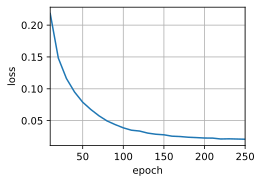

In [91]:
"""训练"""
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, self_d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = self_d2l.load_data_nmt(batch_size, num_steps)
encoder = self_d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = self_d2l.EncoderDecoder(encoder, decoder)
train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

## 预测

In [99]:
"""预测"""
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = self_d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, dtype=torch.long, device=device), dim=0)
    enc_outputs = net.encoder(enc_X, enc_valid_len)
    dec_state = net.decoder.init_state(enc_outputs, enc_valid_len)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], dtype=torch.long, device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    for _ in range(num_steps):
        Y, dec_state = net.decoder(dec_X, dec_state)
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq

In [123]:
"""bleu评分一下"""
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {self_d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est bon .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


# 自注意力和位置编码

## 自注意力

In [90]:
num_hiddens, num_heads = 100, 5
attention = self_d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens, num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [91]:
import math
import torch
from torch import nn
from self_d2l import torch as self_d2l

In [92]:
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape

torch.Size([2, 4, 100])

## 位置编码(PositionalEncoding)
公式：$$ p  _{i, 2j} = sin(\frac{i}{10000^{2j/d}})$$

$$ p  _{i,2j+1} = cos(\frac{i}{a0000^{2j/d}})$$

In [94]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, drop_out, max_len = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(drop_out)
        # 创建一个足够长的P 用来存放位置信息
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype = torch.float32).reshape(-1, 1) / torch.pow(10000, 
                                                            torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X) # 从零开始2个一取
        self.P[:, :, 1::2] = torch.cos(X) # 从1开始2个一取
    def forward(self, X):
        # 在位置嵌入矩阵P中，行代表词元在序列中的位置，列代表位置编码的不同维度
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

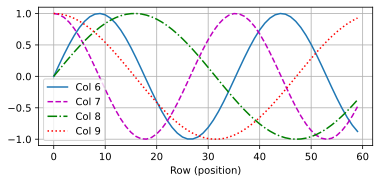

In [95]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0) # drop_out = 0表示全部都看
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
self_d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])

## 绝对位置信息
用二进制进行编码 

In [97]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


torch.Size([1, 1, 60, 32])


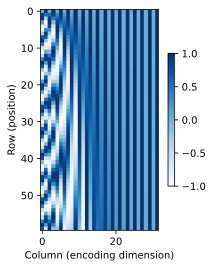

In [98]:
import self_self_d2l
# 高位二进制频率高，可以绘制热力图
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
print(P.shape)
self_self_d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

# Transformer

In [276]:
import math
import pandas as pd
import torch
from torch import nn
import self_d2l

## 多头注意力(MultiHeadAttention)

In [278]:
def masked_softmax(X, valid_lens):
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1) # 变成一维
    X = self_d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
    # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
    return nn.functional.softmax(X.reshape(shape), dim=-1)
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [279]:
def transpose_qkv(X, num_heads):
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1) # 把x最后一个维度改成num_heads * _
    X = X.permute(0, 2, 1, 3) # 把batch维度和head维度放在一起
    return X.reshape(-1, X.shape[2], X.shape[3]) # 变成3维，可以直接放到attention里面
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [280]:
class MultiHeadAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, 
                num_hiddens, 
                num_heads, dropout, bias = False, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        # query, key, value, output的权重初始化
        self.W_q = nn.Linear(query_size, num_hiddens, bias = bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias = bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias = bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias = bias)
    def forward(self, queries, keys, values, valid_lens):
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        if valid_lens is not None:
            # q, k, v的形状改变之后，是（num_heads*batch_size, 查询个数（一个句子里单词的个数），vocab_size / num_heads）
            # 所以相当于batch维度变大了head倍，所以valid重复head次
            valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
        # output_concat的形状:(batch_size*num_heads，查询的个数，num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)
        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [281]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [282]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

## transformer实现

In [300]:
import math
import pandas as pd
import torch
from torch import nn
import self_d2l

### 基于位置的前馈神经网络(PositionWiseFFN)

In [302]:
class PositionWiseFFN(nn.Module): # FFN Feed Forward Network 就是 MLP
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_output, **kwargs):
        super().__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_output)
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

改变张量最里层的尺寸

In [304]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones(2, 3, 4))[0]

tensor([[ 0.6492, -0.5665,  0.3579,  0.4217, -0.1419,  0.6393, -1.0048,  0.9798],
        [ 0.6492, -0.5665,  0.3579,  0.4217, -0.1419,  0.6393, -1.0048,  0.9798],
        [ 0.6492, -0.5665,  0.3579,  0.4217, -0.1419,  0.6393, -1.0048,  0.9798]],
       grad_fn=<SelectBackward0>)

### 使用残差连接和层归一化(AddNorm)
层归一化和批量归一化的区别

In [306]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1,2], [2, 3]], dtype = torch.float32)
print('layer norm:', ln(X),'\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


残差连接和层归一化

In [308]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

加法操作后输出张量的形状相同

In [310]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones(2, 3, 4), torch.ones(2, 3, 4)).shape

torch.Size([2, 3, 4])

### 编码器中的一个层(EncoderBlock)

下面的EncoderBlock类包含两个子层：多头自注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层规范化。

In [313]:
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, 
                 dropout, use_bias = False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, 
                                            dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

Transformer编码器中的任何层都不会改变其输入的形状

In [315]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

### Transformer编码器(PositionalEncoding + TransformerEncoder)

位置编码

In [318]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_hiddens, drop_out, max_len = 1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(drop_out)
        # 创建一个足够长的P 用来存放位置信息
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype = torch.float32).reshape(-1, 1) / torch.pow(10000, 
                                                            torch.arange(0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X) # 从零开始2个一取
        self.P[:, :, 1::2] = torch.cos(X) # 从1开始2个一取
    def forward(self, X):
        # 在位置嵌入矩阵P中，行代表词元在序列中的位置，列代表位置编码的不同维度
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

transformer编码器

In [320]:
class TransformerEncoder(self_d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias = False, **kwargs):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i), 
                                 EncoderBlock(key_size, query_size, value_size, num_hiddens,
                                 norm_shape, ffn_num_input, ffn_num_hiddens,
                                 num_heads, dropout, use_bias))
    def forward(self, X, valid_lens, *args):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # self.embedding(X)的结果通常比较小，
                                            # 乘一个math.sqrt(self.num_hiddens)使得结果与position coding的大小差不多大
        self.attention_weights = [None] * len(self.blks) # 可视化的东西
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights
        return X

一个两层的transformer编码器

In [322]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

### Transformer解码器(DecoderBlock)

In [324]:
class DecoderBlock(nn.Module):
    """解码器中第 i 个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = self_d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)
    def forward(self, X, state):
        # state中有三个东西，编码器输出形状，有效长度和过去的key value
        enc_outputs, enc_valid_lens = state[0], state[1]
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat(state[2][self.i], X, axis = 1)
            state[2][self.i] = key_values
        # 如果训练的话要把后面的输入遮住，预测的话不用遮住
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else :
            dec_valid_lens = None
        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在“编码器－解码器”注意力中进行缩放点积计算和残差连接中进行加法计算，编码器和解码器的特征维度都是num_hiddens。

In [326]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [339]:
class TransformerDecoder(self_d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, 
                 norm_shape, ffn_num_input, ffn_num_hiddens, 
                 num_heads, num_layers, dropout, use_bias = False, **kwargs):
        super().__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block" + str(i), 
                                 DecoderBlock(key_size, query_size, value_size, num_hiddens,
                                 norm_shape, ffn_num_input, ffn_num_hiddens,
                                 num_heads, dropout, use_bias))
        # 做输出
        self.dense = nn.Linear(num_hiddens, vocab_size)

    # 预测时用来存init_state
    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens)) # self.embedding(X)的结果通常比较小，
                                            # 乘一个math.sqrt(self.num_hiddens)使得结果与position coding的大小差不多大
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]# 可视化的东西
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state
    @property
    def attention_weights(self):
        return self._attention_weights

### 训练

loss 0.032, 2708.1 tokens/sec on cpu


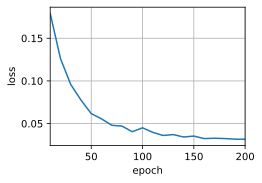

In [342]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, self_d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = self_d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = self_d2l.EncoderDecoder(encoder, decoder)
self_d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，使用Transformer模型将一些英语句子翻|译成法语，并且计算它们的BLEU分数。

In [347]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = self_d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {self_d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => je sais .,  bleu 0.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


编码器自注意力权重的形状为（编码器层数，注意力头数，num_steps或查询的数目，num_steps或“键－值”对的数目）

In [354]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

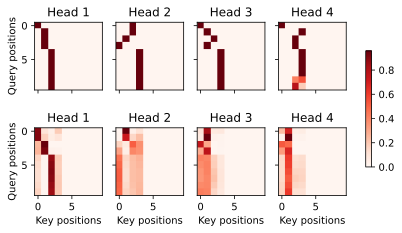

In [356]:
self_d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

为了可视化解码器的自注意力权重和“编码器－解码器”的注意力权重，我们需要完成更多的数据操作工作。例如用零填充被掩蔽住的注意力权重。值得注意的是，解码器的自注意力权重和“编码器－解码器”的注意力权重都有相同的查询：即以序列开始词元（beginning-of-sequence,BOS）打头，再与后续输出的词元共同组成序列。

In [373]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自注意力的自回归属性，查询不会对当前位置之后的“键－值”对进行注意力计算

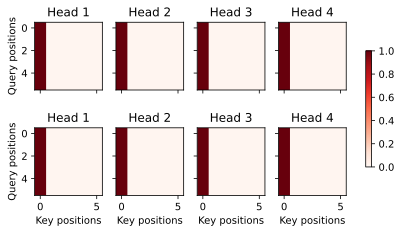

In [368]:
# Plusonetoincludethebeginning-of-sequencetoken
self_d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器的自注意力的情况类似，通过指定输入序列的有效长度，输出序列的查询不会与输入序列中填充位置的词元进行注意力计算。

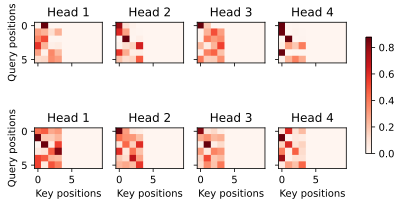

In [370]:
self_d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))